In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.patches import FancyArrowPatch
from watermark import watermark
print(watermark())
print(watermark(packages="pandas,numpy,matplotlib,seaborn"))
mpl.rcParams['pdf.fonttype'] = 42


Last updated: 2025-06-13T14:55:11.244139-07:00

Python implementation: CPython
Python version       : 3.13.3
IPython version      : 9.3.0

Compiler    : MSC v.1943 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 63 Stepping 2, GenuineIntel
CPU cores   : 72
Architecture: 64bit

pandas    : 2.2.3
numpy     : 2.1.2
matplotlib: 3.10.3
seaborn   : 0.13.2



# Get Simulation Results

In [2]:
res = pd.read_csv('sum_stats_wtruth.csv')

In [3]:
res["perfect"] = (res["fp"] == 0)

# Get Codebooks and their statistics

In [4]:
codebooks = {code:pd.read_csv("codebooks/" + code + "cb.csv") for code in np.unique(res.code)}

ncws_dict = {code:len(codebooks[code]) for code in np.unique(res.code) }
nimgs_dict = {}
for code in np.unique(res.code):
    if code[:7] == "seqFISH":
        nimgs_dict[code] = np.shape(codebooks[code].iloc[:,1:])[1]*(len(np.unique(codebooks[code].iloc[:,1:])))
    else:
        nimgs_dict[code] = np.shape(codebooks[code].iloc[:,1:])[1]*(len(np.unique(codebooks[code].iloc[:,1:]))-1)


In [5]:
codebook_weights = {}
for code in codebooks.keys():
    if code == 'RS_q8_n9_k6_w5':
        codebook_weights[code] = 5
    elif code[:7] != "seqFISH":
        codebook_weights[code] = (codebooks[code].iloc[:, 1:] != 0).sum(axis=1)[0]
    elif code in ['seqFISHDNA_2020', 'seqFISH_intron_2018', 'seqFISH_q12_n5_k4', 'seqFISH_q16_n5_k3']:
        codebook_weights[code] = 5
    else:
        codebook_weights[code] = 4

 # Make better names for some columns

In [6]:
res.loc[res.code == "Hamming_q2_n16_k11_w4cb_MERFISH_2015", "code"] = "MERFISH_2015"
ncws_dict["MERFISH_2015"] = ncws_dict["Hamming_q2_n16_k11_w4cb_MERFISH_2015"]
nimgs_dict["MERFISH_2015"] = nimgs_dict["Hamming_q2_n16_k11_w4cb_MERFISH_2015"]
codebook_weights["MERFISH_2015"] = codebook_weights["Hamming_q2_n16_k11_w4cb_MERFISH_2015"]

res.loc[res.code == "seqFISH_q25_n4_k3_w4cb_assign_3t3_ribo_271_attempt1", "code"] = "q25_n4_k3"
ncws_dict["q25_n4_k3"] = ncws_dict["seqFISH_q25_n4_k3_w4cb_assign_3t3_ribo_271_attempt1"]
nimgs_dict["q25_n4_k3"] = nimgs_dict["seqFISH_q25_n4_k3_w4cb_assign_3t3_ribo_271_attempt1"]
codebook_weights["q25_n4_k3"] = codebook_weights["seqFISH_q25_n4_k3_w4cb_assign_3t3_ribo_271_attempt1"]

res.loc[res.code == "seqFISH_n4k3q25_parity_check", "code"] = "full_q25_n4_k3"
ncws_dict["full_q25_n4_k3"] = ncws_dict["seqFISH_n4k3q25_parity_check"]
nimgs_dict["full_q25_n4_k3"] = nimgs_dict["seqFISH_n4k3q25_parity_check"]
codebook_weights["full_q25_n4_k3"] = codebook_weights["seqFISH_n4k3q25_parity_check"]

res.loc[res.code == "unstructured_100bit_w5_md6", "code"] = "NL_w5_md6"
ncws_dict["NL_w5_md6"] = ncws_dict["unstructured_100bit_w5_md6"]
nimgs_dict["NL_w5_md6"] = nimgs_dict["unstructured_100bit_w5_md6"]
codebook_weights["NL_w5_md6"] = codebook_weights["unstructured_100bit_w5_md6"]

res.loc[res.code == "q11_n10_k7_w4cb_pool1", "code"] = "q11n10k7w4"
ncws_dict["q11n10k7w4"] = ncws_dict["q11_n10_k7_w4cb_pool1"]
nimgs_dict["q11n10k7w4"] = nimgs_dict["q11_n10_k7_w4cb_pool1"]
codebook_weights["q11n10k7w4"] = codebook_weights["q11_n10_k7_w4cb_pool1"]


In [7]:
res["Number of Barcodes"] = res["nbarcodes"]
reps_summed = res.groupby(['code','ncodewords', 'Number of Barcodes']).sum()
reps_summed['correct_barcodes'] = reps_summed['gene_encoding_barcodes'] - reps_summed['fp']
reps_summed["Efficiency"] = reps_summed['correct_barcodes']/reps_summed['total_true_cnts']
reps_summed["False Discovery Rate"] = reps_summed['fp']/reps_summed['gene_encoding_barcodes']
reps_summed.reset_index(inplace=True)
reps_summed["ylabel"] = [code + "_ncws" + str(ncws_dict[code]) + "_nimgs" + str(nimgs_dict[code]) for code in reps_summed.code]
reps_summed["prop_perfect"] = reps_summed["perfect"]/500

 # Make Table of plot data

In [8]:
fdr_table = reps_summed.set_index("Number of Barcodes")
fdr_table.reset_index(inplace=True)
fdr_table = fdr_table.set_index(["code", "Number of Barcodes"]) #, "Number of Codewords"])
fdr_table = fdr_table.loc[:,["False Discovery Rate", "Efficiency"]]
fdr_table = fdr_table.unstack("Number of Barcodes")


In [9]:
code_mds = {
    'seqFISH_intron_2018' : 2,
    'seqFISHp2019_used_only': 2,
    'seqFISHDNA_2020' : 2,
    'MERFISH_2015' : 4,
    'RS_q13_n13_k9_w5' : 5,
    'RS_q13_n10_k6_w6' : 5,
    'RSq13n10md5w6' : 5,
    'q17n12md5w5' : 5,
    'q11n10k7w4' : 4,
    'RS_q8_n9_k6_w5' : 4,
    'RS_q8_n9_k6_w6': 4,
    'MERFISH_2019' : 4,
    'seqFISHp2019_repetition': 2
}

code_q = {
    'seqFISH_intron_2018' : 12,
    'seqFISHp2019_used_only' : 20,
    'seqFISHDNA_2020' : 16,
    'MERFISH_2015' : 2,
    'RS_q13_n13_k9_w5' : 13,
    'RS_q13_n10_k6_w6' : 13,
    'RSq13n10md5w6' : 13,
    'q17n12md5w5' : 17,
    '#RS_q11_n10_k7_w4' : 11,
    'q11n10k7w4' : 11,
    'RS_q8_n9_k6_w5' : 8,
    'RS_q8_n9_k6_w6': 8,
    'MERFISH_2019' : 2,
    'seqFISHp2019_repetition': 20
}

code_n = {
    'seqFISH_intron_2018' : 5,
    'seqFISHp2019_used_only' : 4,
    'seqFISHDNA_2020' : 5,
    'MERFISH_2015' : 16,
    'RS_q13_n13_k9_w5' : 13,
    'RS_q13_n10_k6_w6' : 10,
    'RSq13n10md5w6' : 10,
    'q17n12md5w5' : 12,
    'q11n10k7w4' : 10,
    'RS_q8_n9_k6_w5' : 9,
    'MERFISH_2019' : 69,
    'seqFISHp2019_repetition': 6
}

In [10]:
reps_summed = reps_summed.loc[reps_summed.ylabel != "RSq13n10md5w6_ncws10560_nimgs120"]

In [11]:
plot_order_dict = {
    'seqFISHp2019_used_only' : 1,
    'seqFISHDNA_2020' : 2,
    'MERFISH_2015' : 3,
    'RS_q13_n13_k9_w5' : 4,
    'RS_q13_n10_k6_w6' : 5,
    'q17n12md5w5' : 6,
    'q11n10k7w4' : 7,
    'RS_q8_n9_k6_w5' : 8,
    'MERFISH_2019' : 9,
    'seqFISH_intron_2018' : 0
}
    

i:  0 ; g[0]:  MERFISH_2015_ncws140_nimgs16
i:  1 ; g[0]:  MERFISH_2019_ncws12903_nimgs69
i:  2 ; g[0]:  NL_w5_md6_ncws12267_nimgs100
i:  3 ; g[0]:  RS_q11_n10_k7_w4_ncws2100_nimgs100
i:  4 ; g[0]:  RS_q13_n10_k6_w6_ncws20160_nimgs120
i:  5 ; g[0]:  RS_q13_n13_k9_w5_ncws15444_nimgs156
i:  6 ; g[0]:  RS_q8_n9_k6_w5_ncws3528_nimgs63
i:  7 ; g[0]:  full_q25_n4_k3_ncws15625_nimgs100
i:  8 ; g[0]:  q11n10k7w4_ncws271_nimgs100
i:  9 ; g[0]:  q17n12md5w5_ncws12672_nimgs192
i:  10 ; g[0]:  q25_n4_k3_ncws271_nimgs100
i:  11 ; g[0]:  seqFISHDNA_2020_ncws1267_nimgs80
i:  12 ; g[0]:  seqFISH_intron_2018_ncws10421_nimgs60
i:  13 ; g[0]:  seqFISH_q12_n5_k4_ncws20736_nimgs60
i:  14 ; g[0]:  seqFISH_q16_n5_k3_ncws4096_nimgs80
i:  15 ; g[0]:  seqFISHp2019_ncws8000_nimgs80
i:  16 ; g[0]:  seqFISHp2019_used_only_ncws3334_nimgs80
code:  seqFISHp2019_used_only


C:\Users\jonat\AppData\Local\Temp\ipykernel_23060\2969658904.py:73: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  lnd_artist = plt.legend(loc='upper right', bbox_to_anchor=(1.85,10))


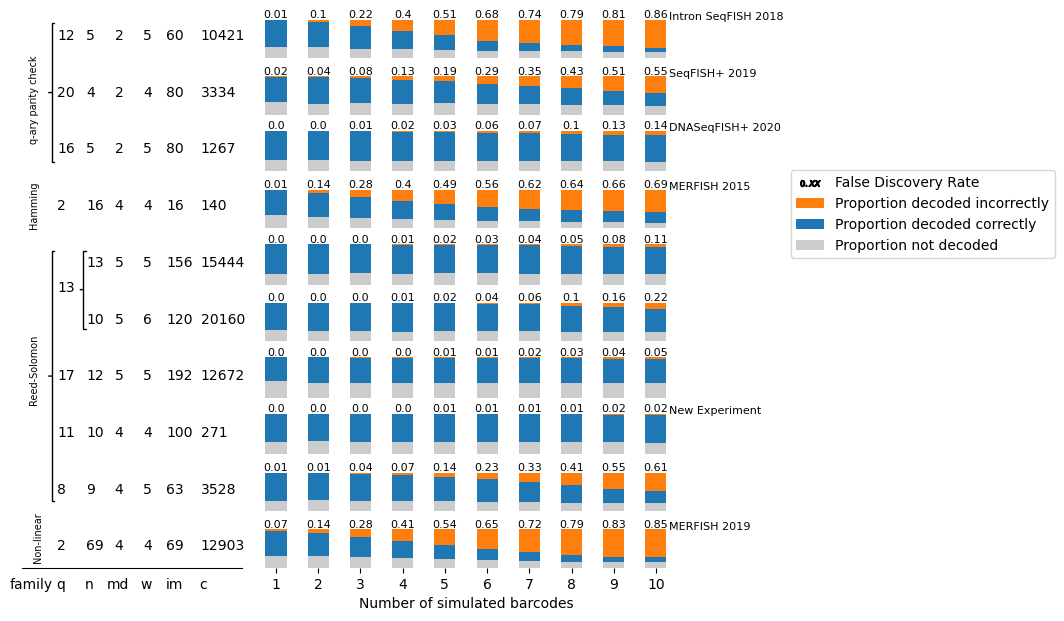

In [12]:
fig = plt.figure(figsize=(7,5.5))
ax = fig.subplot_mosaic(
    [
        ["label_tree", "seqFISH_intron_2018"],
        ["label_tree", "seqFISHp2019_used_only"],
        ["label_tree", 'seqFISHDNA_2020'],
        ["label_tree", "MERFISH_2015"],
        ["label_tree", "RS_q13_n13_k9_w5"],
        ["label_tree", "RS_q13_n10_k6_w6"],
        ["label_tree", "q17n12md5w5"],
        ["label_tree", "q11n10k7w4"],
        ["label_tree", "RS_q8_n9_k6_w5"],
        ["label_tree", "MERFISH_2019"],
    ],
    width_ratios=[1, 2],
)
ax["label_tree"].spines.top.set_visible(False)
ax["label_tree"].spines.right.set_visible(False)
ax["label_tree"].spines.left.set_visible(False)
ax["label_tree"].spines.bottom.set_visible(False)
ax["label_tree"].tick_params(bottom=False, left=False, labelleft=False)


ax["label_tree"].plot(["family", "q", "n", "md", "w", "im", "c", ""], [1,1,1,1,1,1,1,1], markersize=0,c="w")
ax["label_tree"].set_ylim(0,1)

tree_height_factor = 9.7

txt_top = 0.96
bar_width = 0.5


for i, grp in enumerate(reps_summed.groupby("ylabel")):
    print("i: ", i, "; g[0]: ", grp[0])
    code = grp[1].code.iloc[0]

    bottom = np.zeros(len(grp[1]))

    eff = grp[1]["Efficiency"]
    false = grp[1]["fp"]/grp[1]['nbarcodes']
    mis = 1 - eff - false
    fdr = grp[1]["False Discovery Rate"]

    if code in ax:
        ax[code].scatter([1],[0.3], s=200,marker = '$0.XX$', color='k', label="False Discovery Rate")
        p = ax[code].bar(grp[1]['Number of Barcodes'], false, bar_width, label="Proportion decoded incorrectly", bottom=1-false, color= "tab:orange")
        ax[code].bar_label(p, np.round(fdr,2),size=8, label="False Discovery Rate")
                          
        p = ax[code].bar(grp[1]['Number of Barcodes'], eff, bar_width, label="Proportion decoded correctly", bottom=mis, color="tab:blue")
        p = ax[code].bar(grp[1]['Number of Barcodes'], mis, bar_width, label="Proportion not decoded", bottom=bottom, color="#cccccc")
    
    
        
        ncws = grp[1].ncodewords.iloc[0]
        
        ax[code].spines.top.set_visible(False)
        ax[code].spines.right.set_visible(False)
        ax[code].spines.left.set_visible(False)
        ax[code].spines.bottom.set_visible(False)
        ax[code].tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)

        if code in code_n and code_n[code] != 6:
            if code_q[code] != 13:
                ax["label_tree"].text(0.9,txt_top-plot_order_dict[code]/tree_height_factor,code_q[code])
            ax["label_tree"].text(1.9,txt_top-plot_order_dict[code]/tree_height_factor,code_n[code])
            ax["label_tree"].text(2.9,txt_top-plot_order_dict[code]/tree_height_factor,code_mds[code])
            ax["label_tree"].text(3.9,txt_top-plot_order_dict[code]/tree_height_factor,codebook_weights[code])
            ax["label_tree"].text(4.7,txt_top-plot_order_dict[code]/tree_height_factor,nimgs_dict[code])
        ax["label_tree"].text(5.9,txt_top-plot_order_dict[code]/tree_height_factor,ncws_dict[code])

ax["label_tree"].spines.bottom.set_visible(True)

lnd_artist = plt.legend(loc='upper right', bbox_to_anchor=(1.85,10))

print("code: ", code)

offset = 0.046
bracket_offset = 0.039 + 0.003



ax["label_tree"].text(0.9,txt_top-plot_order_dict["RS_q13_n13_k9_w5"]/tree_height_factor-offset,code_q["RS_q13_n13_k9_w5"])
ax["label_tree"].annotate("",
                          (1.9,txt_top-plot_order_dict["RS_q13_n13_k9_w5"]/tree_height_factor - bracket_offset),
                          (1.6,txt_top-plot_order_dict["RS_q13_n13_k9_w5"]/tree_height_factor - bracket_offset), 
                          arrowprops={'arrowstyle':"-[,widthB=2.8, lengthB=0.2,angleB=0"}
                         )

ax['seqFISH_intron_2018'].text(10.3,1,"Intron SeqFISH 2018",size=8)
ax['seqFISHp2019_used_only'].text(10.3,1,"SeqFISH+ 2019",size=8)
ax['seqFISHDNA_2020'].text(10.3,1,"DNASeqFISH+ 2020",size=8)
ax['MERFISH_2015'].text(10.3,1,"MERFISH 2015",size=8)
ax['q11n10k7w4'].text(10.3,1,"New Experiment",size=8)
ax['MERFISH_2019'].text(10.3,1,"MERFISH 2019",size=8)


ax['MERFISH_2019'].set_xticks([1,2,3,4,5,6,7,8,9,10])
ax['MERFISH_2019'].set_xlabel("Number of simulated barcodes")
ax['MERFISH_2019'].tick_params(bottom=True, labelbottom=True)


brackets = []
pc_bracket = FancyArrowPatch((0.0,0.8),(0.2,0.8), arrowstyle={'arrowstyle':"-[,widthB=0.0, lengthB=0.2, angleB=0"}, mutation_scale=42)

fig.text(0.06,txt_top-plot_order_dict["seqFISHDNA_2020"]/tree_height_factor+0.02,"q-ary parity check",rotation="vertical",fontsize=7)
ax["label_tree"].annotate("",
                          (0.8,txt_top-plot_order_dict["seqFISHp2019_used_only"]/tree_height_factor + 0.007), #-bracket_offset),
                          (0.5,txt_top-plot_order_dict["seqFISHp2019_used_only"]/tree_height_factor + 0.007), #-bracket_offset), 
                          arrowprops={'arrowstyle':"-[,widthB=5, lengthB=0.2,angleB=0"}
                         )

fig.text(0.06,0.62,"Hamming",rotation="vertical",fontsize=7)

RS_bracket = FancyArrowPatch((45,265),(55,265), arrowstyle="-[,widthB=2.1, lengthB=0.2, angleB=0", mutation_scale=42)
brackets.append(RS_bracket)
fig.text(0.06,0.3,"Reed-Solomon",rotation="vertical",fontsize=7)
ax["label_tree"].annotate("",
                          (0.8,txt_top-plot_order_dict["q17n12md5w5"]/tree_height_factor + 0.007),
                          (0.5,txt_top-plot_order_dict["q17n12md5w5"]/tree_height_factor + 0.007),
                          arrowprops={'arrowstyle':"-[,widthB=9, lengthB=0.2,angleB=0"}
                         )

ax["label_tree"].text(0.06,txt_top-plot_order_dict["MERFISH_2019"]/tree_height_factor - 0.02,"Non-linear",rotation="vertical",fontsize=7)

plt.subplots_adjust(left=0.05,
                    bottom=0.0, 
                    right=1.0, 
                    top=1, 
                    wspace=0.01, 
                    hspace=0.4)

plt.savefig('fig2A.pdf', bbox_inches = 'tight') #, pad_inches = 5) # bbox_extra_artists=[lnd_artist])

In [13]:
code_prop_perfect = reps_summed.set_index(["Number of Barcodes", "code"])["prop_perfect"].unstack("code")

In [14]:
code_prop_perfect

code,MERFISH_2015,MERFISH_2019,NL_w5_md6,RS_q11_n10_k7_w4,RS_q13_n10_k6_w6,RS_q13_n13_k9_w5,RS_q8_n9_k6_w5,full_q25_n4_k3,q11n10k7w4,q17n12md5w5,q25_n4_k3,seqFISHDNA_2020,seqFISH_intron_2018,seqFISH_q12_n5_k4,seqFISH_q16_n5_k3,seqFISHp2019,seqFISHp2019_used_only
Number of Barcodes,,,,,,,,,,,,,,,,,
1,0.996,0.952,0.998,0.996,0.998,1.000,0.996,0.972,1.000,1.000,0.998,1.000,0.992,0.984,0.996,0.978,0.988
2,0.846,0.824,0.996,0.994,0.996,0.994,0.984,0.880,1.000,1.000,0.996,0.996,0.878,0.756,0.972,0.874,0.948
3,0.588,0.588,0.966,0.960,0.996,0.996,0.928,0.714,0.994,0.994,0.994,0.976,0.670,0.452,0.894,0.734,0.868
4,0.346,0.360,0.894,0.934,0.984,0.968,0.838,0.458,0.988,0.990,0.986,0.948,0.370,0.204,0.820,0.486,0.748
5,0.154,0.202,0.824,0.886,0.940,0.944,0.686,0.314,0.976,0.974,0.966,0.892,0.222,0.062,0.668,0.324,0.610
6,0.072,0.074,0.696,0.808,0.874,0.894,0.514,0.168,0.972,0.956,0.982,0.806,0.052,0.020,0.516,0.142,0.368
7,0.030,0.028,0.564,0.696,0.808,0.874,0.350,0.082,0.966,0.918,0.938,0.748,0.030,0.004,0.358,0.058,0.302
8,0.006,0.006,0.398,0.548,0.688,0.808,0.252,0.032,0.934,0.882,0.886,0.636,0.008,0.000,0.276,0.038,0.164
9,0.000,0.004,0.280,0.468,0.590,0.690,0.088,0.008,0.904,0.806,0.868,0.558,0.004,0.000,0.160,0.010,0.082


In [15]:
code2label = {
    'seqFISH_q12_n5_k4cb': "Q-ary Parity Check - q12 n5 k4: 20736 codewords",
    'seqFISH_intron_2018cb': 'Intron seqFISH 2018 Q-ary Parity Check - q12 n5 k4: 10421 codewords',
    'Hamming_q2_n16_k11_w4cb_MERFISH_2015cb': 'Hamming - q2 n16 k11 w4: 140 codewords',
    'MERFISH_2019cb': 'MERFISH 2019 Non-Linear - q2 n69 w4: 12903 codewords',
    'RS_q8_n9_k6_w5cb': 'Reed-Solomon q8 n9 k6 w5: 3528 codewords',
    'seqFISH_q16_n5_k3cb': 'Q-ary Parity Check - q16 n5 k3: 4096 codewords',
    'seqFISHp2019cb': 'Q-ary Parity Check - q20 n4 k3: 8000 codewords',
    'RS_q13_n10_k6_w6cb': 'Reed-Solomon - q13 n10 k6 w6: 20160',
    'unstructured_100bit_w5_md6cb': 'Non-Linear - q2 n100 w5 md6: 12267 codewords', 
    'seqFISH_n4k3q25_parity_checkcb': 'Q-ary Parity Check - q25 n4 k3: 15625 codewords',
    'seqFISHp2019_used_onlycb': 'RNA seqFISH+ Q-ary Parity Check - q20 n4 k3: 3334 codewords',
    'seqFISHDNA_2020cb': 'DNA seqFISH+ 2020 Q-ary Parity Check - q16 n5 k3: 1267 codewords',
    'RS_q13_n13_k9_w5cb': 'Reed-Solomon - q13 n13 k9 w5: 15444 codewords',
    'RS_q11_n10_k7_w4cb': 'Reed-Solomon - q11 n10 k7 w4: 2100 codewords',
    'seqFISH_q25_n4_k3_w4cb_assign_3t3_ribo_271_attempt1cb': 'Q-ary Parity Check - q25 n4 k3: 271 codewords',
    'q17n12md5w5cb': 'Reed-Solomon - q17 n12 md5 w5: 12672 codewords',
    'q11_n10_k7_w4cb_pool1cb': 'Reed-Solomon - q11 n10 k7 w4: 271 codewords'
}

dashed = ['seqFISH_q12_n5_k4',
'MERFISH_2015',
'MERFISH_2019',
'full_q25_n4_k3',
'seqFISHp2019',
'seqFISH_intron_2018',
'seqFISHp2019_used_only']

In [16]:
code_prop_perfect.loc[5, :].sort_values()

code
seqFISH_q12_n5_k4         0.062
MERFISH_2015              0.154
MERFISH_2019              0.202
seqFISH_intron_2018       0.222
full_q25_n4_k3            0.314
seqFISHp2019              0.324
seqFISHp2019_used_only    0.610
seqFISH_q16_n5_k3         0.668
RS_q8_n9_k6_w5            0.686
NL_w5_md6                 0.824
RS_q11_n10_k7_w4          0.886
seqFISHDNA_2020           0.892
RS_q13_n10_k6_w6          0.940
RS_q13_n13_k9_w5          0.944
q25_n4_k3                 0.966
q17n12md5w5               0.974
q11n10k7w4                0.976
Name: 5, dtype: float64

In [17]:
sort_code_pp = code_prop_perfect.loc[5, :].sort_values(ascending=False)

In [18]:
code2label = {
    'seqFISH_q12_n5_k4': "Q-ary Parity Check - q12 n5 k4: 20736 codewords",
    'seqFISH_intron_2018': 'Intron seqFISH 2018 Q-ary Parity Check - q12 n5 k4: 10421 codewords',
    'MERFISH_2015': 'Hamming - q2 n16 k11 w4: 140 codewords',
    'MERFISH_2019': 'MERFISH 2019 Non-Linear - q2 n69 w4: 12903 codewords',
    'RS_q8_n9_k6_w5': 'Reed-Solomon q8 n9 k6 w5: 3528 codewords',
    'seqFISH_q16_n5_k3': 'Q-ary Parity Check - q16 n5 k3: 4096 codewords',
    'seqFISHp2019': 'Q-ary Parity Check - q20 n4 k3: 8000 codewords',
    'RS_q13_n10_k6_w6': 'Reed-Solomon - q13 n10 k6 w6: 20160',
    'NL_w5_md6': 'Non-Linear - q2 n100 w5 md6: 12267 codewords', 
    'full_q25_n4_k3': 'Q-ary Parity Check - q25 n4 k3: 15625 codewords',
    'seqFISHp2019_used_only': 'RNA seqFISH+ Q-ary Parity Check - q20 n4 k3: 3334 codewords',
    'seqFISHDNA_2020': 'DNA seqFISH+ 2020 Q-ary Parity Check - q16 n5 k3: 1267 codewords',
    'RS_q13_n13_k9_w5': 'Reed-Solomon - q13 n13 k9 w5: 15444 codewords',
    'RS_q11_n10_k7_w4': 'Reed-Solomon - q11 n10 k7 w4: 2100 codewords',
    'q25_n4_k3': 'Q-ary Parity Check - q25 n4 k3: 271 codewords',
    'q17n12md5w5': 'Reed-Solomon - q17 n12 md5 w5: 12672 codewords',
    'q11n10k7w4': 'Reed-Solomon - q11 n10 k7 w4: 271 codewords'
}

Text(0, 0.5, 'Proportion of replicates decoded\nwithout false discoveries')

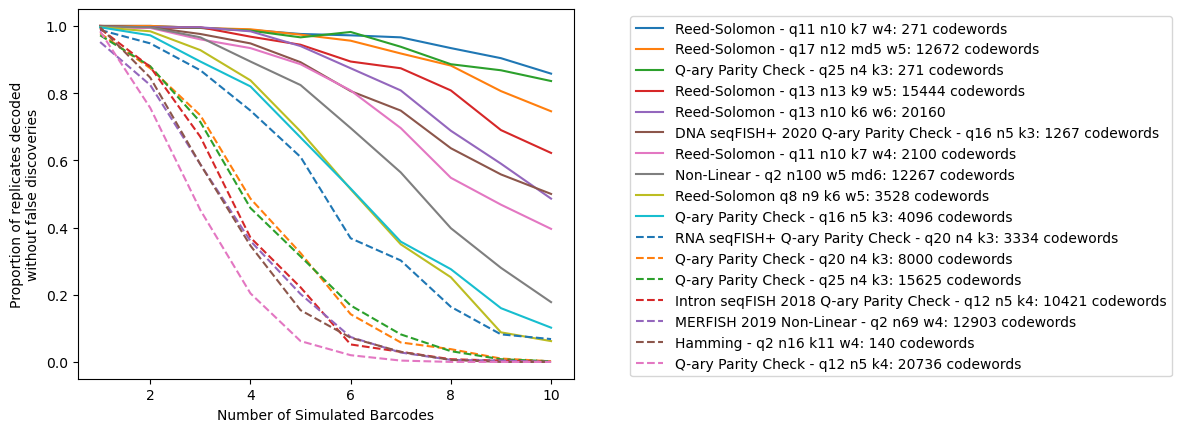

In [19]:
for code in sort_code_pp.index:
    prop_perfect = code_prop_perfect[code]
    if code in dashed:
        plt.plot(range(1,11), prop_perfect, '--',label=code2label[code])
    else:
        plt.plot(range(1,11), prop_perfect, '-',label=code2label[code])

plt.legend(bbox_to_anchor=(1.1,1))
plt.xlabel("Number of Simulated Barcodes")
plt.ylabel("Proportion of replicates decoded\nwithout false discoveries")

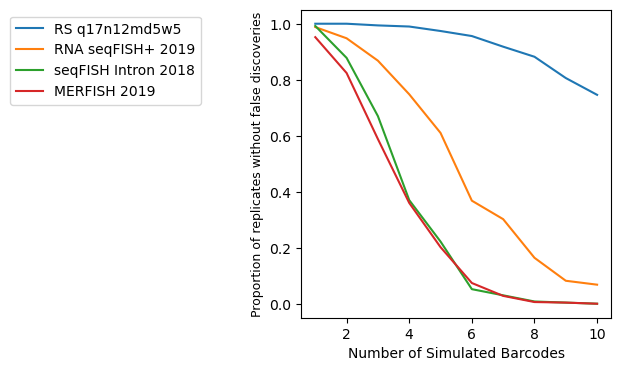

In [20]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
lbl = ['RS q17n12md5w5', 'RNA seqFISH+ 2019', 'seqFISH Intron 2018', 'MERFISH 2019']
for i, code in enumerate(['q17n12md5w5', 'seqFISHp2019_used_only', 'seqFISH_intron_2018', 'MERFISH_2019']):
    prop_perfect = code_prop_perfect[code]
    ax.plot(range(1,11), prop_perfect, '-',label=lbl[i]) #code2label[code])

ax.legend(bbox_to_anchor=(-0.3,1))
ax.set_xlabel("Number of Simulated Barcodes")
ax.set_ylabel("Proportion of replicates without false discoveries", size=9)
plt.savefig("Fig1F.pdf")